# Загрузка данных

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("starsw/intersection-flow-5k")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/intersection-flow-5k


In [ ]:
import os
import xml.etree.ElementTree as ET
from PIL import Image

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.ops import box_convert

from transformers import DetrImageProcessor, DetrForObjectDetection, DetrConfig
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.ops import box_iou

from tqdm import tqdm

from torch.optim import AdamW

import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Загрузка модели

In [4]:
class2id = {
    "vehicle": 0,
    "bus": 1,
    "bicycle": 2,
    'pedestrian': 3,
    'engine': 4,
    'truck': 5,
    'tricycle': 6,
    'obstacle': 7,
}

In [ ]:
model_name = "facebook/detr-resnet-50"

image_processor = DetrImageProcessor.from_pretrained(model_name)
model = DetrForObjectDetection.from_pretrained(
    model_name,
    num_labels=len(class2id),
    id2label={v:k for k,v in class2id.items()},
    label2id=class2id,
    ignore_mismatched_sizes=True
)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

print('model loaded')

In [6]:
# for p in model.parameters():
#     p.requires_grad = False

# for p in model.class_labels_classifier.parameters():
#     p.requires_grad = True

# for p in model.bbox_predictor.parameters():
#     p.requires_grad = True
# # 

In [7]:
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
frozen = sum(p.numel() for p in model.parameters() if not p.requires_grad)

print(f"Обучаемые параметры: {trainable:,}")
print(f"Замороженные:        {frozen:,}")
print(f"Всего:               {trainable + frozen:,}")


Обучаемые параметры: 41,281,037
Замороженные:        222,400
Всего:               41,503,437


## Датасет класс

In [8]:
class IntersectionFlowDataset(Dataset):
    def __init__(self, images_dir, labels_dir, image_processor):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.image_processor = image_processor

        self.image_files = sorted([
            f for f in os.listdir(images_dir)
            if f.endswith((".jpg", ".png", ".jpeg"))
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_name = self.image_files[idx]
        image_path = os.path.join(self.images_dir, image_name)
        label_path = os.path.join(
            self.labels_dir,
            os.path.splitext(image_name)[0] + ".txt"
        )

        image = Image.open(image_path).convert("RGB")
        w, h = image.size

        coco_annotations = []

        if os.path.exists(label_path):
            with open(label_path) as f:
                for line in f:
                    cls, cx, cy, bw, bh = map(float, line.split())

                    x = (cx - bw / 2) * w
                    y = (cy - bh / 2) * h
                    bw_px = bw * w
                    bh_px = bh * h

                    coco_annotations.append({
                        "bbox": [x, y, bw_px, bh_px], # левый верхний угол и ширина и высота бокса
                        "category_id": int(cls),
                        "area": bw_px * bh_px,
                        "iscrowd": 0
                    })

        target = {
            "image_id": idx,
            "annotations": coco_annotations
        }

        encoding = self.image_processor(
            images=image,
            annotations=target,
            return_tensors="pt"
        )

        return {
            "pixel_values": encoding["pixel_values"].squeeze(0),
            "labels": encoding["labels"][0]
        }


In [9]:
def collate_fn(batch):
    pixel_values = torch.stack([b["pixel_values"] for b in batch])
    labels = [b["labels"] for b in batch]
    return {
        "pixel_values": pixel_values,
        "labels": labels
    }


In [10]:
train_dataset = IntersectionFlowDataset(
    images_dir="/kaggle/input/intersection-flow-5k/Intersection-Flow-5K/images/train",
    labels_dir="/kaggle/input/intersection-flow-5k/Intersection-Flow-5K/labels/train",
    image_processor=image_processor
)

train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)

val_dataset = IntersectionFlowDataset(
    images_dir="/kaggle/input/intersection-flow-5k/Intersection-Flow-5K/images/val",
    labels_dir="/kaggle/input/intersection-flow-5k/Intersection-Flow-5K/labels/val",
    image_processor=image_processor
)

val_loader = DataLoader(
    val_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

test_dataset = IntersectionFlowDataset(
    images_dir="/kaggle/input/intersection-flow-5k/Intersection-Flow-5K/images/test",
    labels_dir="/kaggle/input/intersection-flow-5k/Intersection-Flow-5K/labels/test",
    image_processor=image_processor
)

test_loader = DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)


In [11]:
example = train_dataset[0]
print(f"""Размер изображения после image_processor модели: {list(example['pixel_values'].shape)}""")
print(f"""Лейблы:\n{example['labels'].class_labels}""")
print(f"""Примеры боксов:\n{example['labels'].boxes[:2]}""")

Размер изображения после image_processor модели: [3, 750, 1333]
Лейблы:
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0,
        0, 2])
Примеры боксов:
tensor([[0.2193, 0.2361, 0.1427, 0.1204],
        [0.0411, 0.0801, 0.0427, 0.0509]])


# Проверка, что даталоадер работает

In [12]:
batch = next(iter(train_loader))

pixel_values = batch["pixel_values"] # [B, 3, H, W]
labels = batch["labels"] # list of dicts

# возьмём первый сэмпл в batch
img_tensor = pixel_values[0]
target = labels[0]


In [13]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

# mean/std из DetrImageProcessor
mean = torch.tensor(image_processor.image_mean).view(3, 1, 1)
std = torch.tensor(image_processor.image_std).view(3, 1, 1)

img = img_tensor.cpu() * std + mean
img = img.clamp(0, 1)

# CHW → HWC
img = img.permute(1, 2, 0).numpy()


In [14]:
h, w, _ = img.shape
boxes = target["boxes"].cpu().numpy()
class_ids = target["class_labels"].cpu().numpy()

xyxy = []

for cx, cy, bw, bh in boxes:
    x1 = (cx - bw / 2) * w
    y1 = (cy - bh / 2) * h
    x2 = (cx + bw / 2) * w
    y2 = (cy + bh / 2) * h
    xyxy.append([x1, y1, x2, y2])


In [15]:
# img = HWC float [0,1]
img_vis = (img * 255).astype(np.uint8)

# убедимся, что память непрерывная
img_vis = np.ascontiguousarray(img_vis)

for (x1, y1, x2, y2), cls in zip(xyxy, class_ids):
    cv2.rectangle(
        img_vis,
        (int(x1), int(y1)),
        (int(x2), int(y2)),
        (0, 255, 0),
        2
    )
    cv2.putText(
        img_vis,
        str(cls),
        (int(x1), int(y1) - 5),
        cv2.FONT_HERSHEY_SIMPLEX,
        1,
        (255, 0, 0),
        2
    )


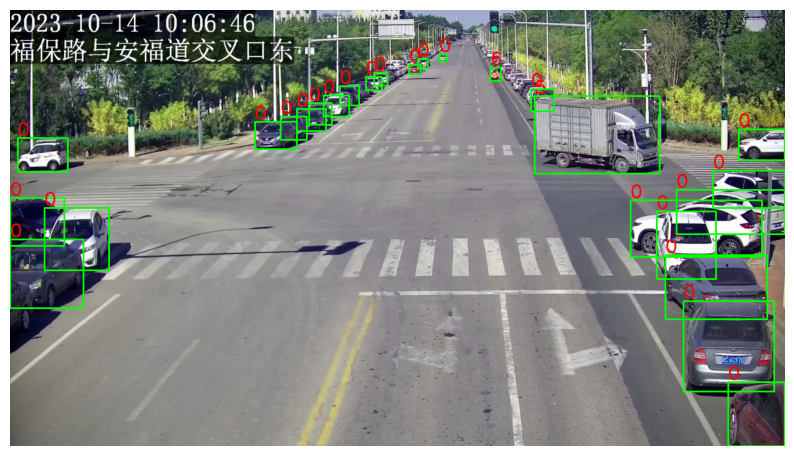

In [16]:
plt.figure(figsize=(10, 10))
plt.imshow(img_vis)
plt.axis("off")
plt.show()


# Обучение

In [17]:
best_map = 0.0
num_epochs = 3

train_losses = []
val_losses = []
val_precisions = []
val_recalls = []

In [18]:
from transformers import get_cosine_schedule_with_warmup


backbone_params = []
other_params = []

for name, param in model.named_parameters():
    if "backbone" in name:
        backbone_params.append(param)
    else:
        other_params.append(param)

optimizer = AdamW([
    {"params": backbone_params, "lr": 1e-5},
    {"params": other_params, "lr": 1e-4},
], weight_decay=1e-4)


num_training_steps = (num_epochs + 30) * len(train_loader)

scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * num_training_steps),
    num_training_steps=num_training_steps,
)

In [19]:
def compute_iou(box1, box2):
    """
    box: [x1, y1, x2, y2] в пикселях
    """
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    inter_area = max(0, x2-x1) * max(0, y2-y1)
    box1_area = (box1[2]-box1[0]) * (box1[3]-box1[1])
    box2_area = (box2[2]-box2[0]) * (box2[3]-box2[1])
    union = box1_area + box2_area - inter_area

    if union == 0:
        return 0
    return inter_area / union


In [20]:
def compute_simple_map(pred_boxes, pred_labels, gt_boxes, gt_labels, iou_threshold=0.5):
    """
    Все координаты в пикселях
    pred_boxes: list of [x1,y1,x2,y2]
    pred_labels: list of class_id
    gt_boxes: list of [x1,y1,x2,y2]
    gt_labels: list of class_id
    """
    tp, fp, fn = 0, 0, 0
    matched = set()
    
    for pb, pl in zip(pred_boxes, pred_labels):
        found = False
        for i, (gb, gl) in enumerate(zip(gt_boxes, gt_labels)):
            if i in matched:
                continue
            if pl == gl and compute_iou(pb, gb) >= iou_threshold:
                tp += 1
                matched.add(i)
                found = True
                break
        if not found:
            fp += 1
    
    fn = len(gt_boxes) - len(matched)
    precision = tp / (tp + fp) if tp+fp>0 else 0
    recall = tp / (tp + fn) if tp+fn>0 else 0
    return precision, recall


In [21]:
for epoch in range(1):
    #   TRAIN
    model.train()
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}")

    running_train_loss = 0
    total_batches = 0

    for batch in loop:
        pixel_values = batch["pixel_values"].to(device)
        labels = [
            {k: v.to(device) for k, v in t.items()}
            for t in batch["labels"]
        ]

        outputs = model(pixel_values=pixel_values, labels=labels)


        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)
        optimizer.step()
        scheduler.step()

        running_train_loss += loss.item()
        total_batches += 1

        loop.set_postfix(loss=loss.item())

    epoch_train_loss = running_train_loss / total_batches
    train_losses.append(epoch_train_loss)
    print(f"Epoch {epoch+1} Train Loss: {epoch_train_loss:.4f}")

    #   VALIDATION
    model.eval()
    
    running_val_loss = 0
    val_batches = 0

    all_prec, all_rec = [], []

    with torch.no_grad():
    
        for batch in tqdm(val_loader):
    
            pixel_values = batch["pixel_values"].to(device)
            labels_batch = batch["labels"]
    
            labels_gpu = [
                {k: v.to(device) for k, v in t.items()} 
                for t in labels_batch
            ]
            outputs = model(pixel_values=pixel_values, labels=labels_gpu)
            val_loss = outputs.loss.item()
    
            running_val_loss += val_loss
            val_batches += 1
    
            # Расчет метрик
            pred_outputs = model(pixel_values=pixel_values)
    
            sizes = torch.tensor([
                (lb["orig_size"][0].item(), lb["orig_size"][1].item()) 
                for lb in labels_batch
            ])
    
            results_batch = image_processor.post_process_object_detection(
                pred_outputs,
                target_sizes=sizes,
                threshold=0.3
            )
                
            for res, target in zip(results_batch, labels_batch):
                
                pred_boxes = res["boxes"].cpu().numpy()      # xyxy пиксели
                pred_labels = res["labels"].cpu().numpy()
            
                orig_h, orig_w = target["orig_size"].tolist()
            
                gt = target["boxes"].cpu().numpy()           # xywh нормализованный
            
                gt_xyxy = np.zeros_like(gt)
                gt_xyxy[:, 0] = (gt[:, 0] - gt[:, 2] / 2) * orig_w
                gt_xyxy[:, 1] = (gt[:, 1] - gt[:, 3] / 2) * orig_h
                gt_xyxy[:, 2] = (gt[:, 0] + gt[:, 2] / 2) * orig_w
                gt_xyxy[:, 3] = (gt[:, 1] + gt[:, 3] / 2) * orig_h
            
                gt_labels = target["class_labels"].cpu().numpy()
            
                prec, rec = compute_simple_map(
                    pred_boxes,
                    pred_labels,
                    gt_xyxy,
                    gt_labels
                )
            
                all_prec.append(prec)
                all_rec.append(rec)

    epoch_val_loss = running_val_loss / val_batches
    val_losses.append(epoch_val_loss)
    
    mean_prec = np.mean(all_prec)
    mean_rec = np.mean(all_rec)
    
    val_precisions.append(mean_prec)
    val_recalls.append(mean_rec)
    
    print(f"Epoch {epoch+1}   "
          f"Train Loss: {epoch_train_loss:.4f}   "
          f"Val Loss: {epoch_val_loss:.4f}   "
          f"Precision: {mean_prec:.4f}   "
          f"Recall: {mean_rec:.4f}")
    
    # Сохранение лучшей модели
    if mean_prec > best_map:
        best_map = mean_prec
        model.save_pretrained(f"/kaggle/working/detr-best-epoch{epoch+1}")
        image_processor.save_pretrained(f"/kaggle/working/detr-best-epoch{epoch+1}")
        print(f"Saved new best model at epoch {epoch+1} with MAP {mean_prec:.4f}")


Epoch 1: 100%|██████████| 686/686 [10:06<00:00,  1.13it/s, loss=2.81]


Epoch 1 Train Loss: 3.2209


100%|██████████| 91/91 [01:23<00:00,  1.08it/s]


Epoch 1   Train Loss: 3.2209   Val Loss: 2.0218   Precision: 0.2383   Recall: 0.5380
Saved new best model at epoch 1 with MAP 0.2383


In [22]:
num_epochs = 10


In [36]:
for epoch in range(num_epochs):
    #   TRAIN
    model.train()
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}")

    running_train_loss = 0
    total_batches = 0

    for batch in loop:
        pixel_values = batch["pixel_values"].to(device)
        labels = [
            {k: v.to(device) for k, v in t.items()}
            for t in batch["labels"]
        ]

        outputs = model(pixel_values=pixel_values, labels=labels)


        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)
        optimizer.step()
        scheduler.step()

        running_train_loss += loss.item()
        total_batches += 1

        loop.set_postfix(loss=loss.item())

    epoch_train_loss = running_train_loss / total_batches
    train_losses.append(epoch_train_loss)
    print(f"Epoch {epoch+1} Train Loss: {epoch_train_loss:.4f}")

    #   VALIDATION
    model.eval()
    
    running_val_loss = 0
    val_batches = 0

    all_prec, all_rec = [], []

    with torch.no_grad():
    
        for batch in tqdm(val_loader):
    
            pixel_values = batch["pixel_values"].to(device)
            labels_batch = batch["labels"]
    
            labels_gpu = [
                {k: v.to(device) for k, v in t.items()} 
                for t in labels_batch
            ]
            outputs = model(pixel_values=pixel_values, labels=labels_gpu)
            val_loss = outputs.loss.item()
    
            running_val_loss += val_loss
            val_batches += 1
    
            # Расчет метрик
            pred_outputs = model(pixel_values=pixel_values)
    
            sizes = torch.tensor([
                (lb["orig_size"][0].item(), lb["orig_size"][1].item()) 
                for lb in labels_batch
            ])
    
            results_batch = image_processor.post_process_object_detection(
                pred_outputs,
                target_sizes=sizes,
                threshold=0.5
            )
    
            for res, target in zip(results_batch, labels_batch):
                
                pred_boxes = res["boxes"].cpu().numpy()      # xyxy пиксели
                pred_labels = res["labels"].cpu().numpy()
            
                orig_h, orig_w = target["orig_size"].tolist()
            
                gt = target["boxes"].cpu().numpy()           # xywh нормализованный
            
                gt_xyxy = np.zeros_like(gt)
                gt_xyxy[:, 0] = (gt[:, 0] - gt[:, 2] / 2) * orig_w
                gt_xyxy[:, 1] = (gt[:, 1] - gt[:, 3] / 2) * orig_h
                gt_xyxy[:, 2] = (gt[:, 0] + gt[:, 2] / 2) * orig_w
                gt_xyxy[:, 3] = (gt[:, 1] + gt[:, 3] / 2) * orig_h
            
                gt_labels = target["class_labels"].cpu().numpy()
            
                prec, rec = compute_simple_map(
                    pred_boxes,
                    pred_labels,
                    gt_xyxy,
                    gt_labels
                )
            
                all_prec.append(prec)
                all_rec.append(rec)
    
    epoch_val_loss = running_val_loss / val_batches
    val_losses.append(epoch_val_loss)
    
    mean_prec = np.mean(all_prec)
    mean_rec = np.mean(all_rec)
    
    val_precisions.append(mean_prec)
    val_recalls.append(mean_rec)
    
    print(f"Epoch {epoch+1}   "
          f"Train Loss: {epoch_train_loss:.4f}   "
          f"Val Loss: {epoch_val_loss:.4f}   "
          f"Precision: {mean_prec:.4f}   "
          f"Recall: {mean_rec:.4f}")
    
    # Сохранение лучшей модели
    if mean_prec > best_map:
        best_map = mean_prec
        model.save_pretrained(f"/kaggle/working/detr-best-epoch{epoch+1}")
        image_processor.save_pretrained(f"/kaggle/working/detr-best-epoch{epoch+1}")
        print(f"Saved new best model at epoch {epoch+1} with MAP {mean_prec:.4f}")


Epoch 1: 100%|██████████| 686/686 [10:09<00:00,  1.13it/s, loss=1.92] 


Epoch 1 Train Loss: 1.6947


100%|██████████| 91/91 [01:20<00:00,  1.12it/s]


Epoch 1   Train Loss: 1.6947   Val Loss: 1.2983   Precision: 0.4462   Recall: 0.6764


Epoch 2: 100%|██████████| 686/686 [10:05<00:00,  1.13it/s, loss=1.91]


Epoch 2 Train Loss: 1.6550


100%|██████████| 91/91 [01:19<00:00,  1.14it/s]


Epoch 2   Train Loss: 1.6550   Val Loss: 1.2151   Precision: 0.5118   Recall: 0.6966
Saved new best model at epoch 2 with MAP 0.5118


Epoch 3: 100%|██████████| 686/686 [10:01<00:00,  1.14it/s, loss=1.27] 


Epoch 3 Train Loss: 1.6159


100%|██████████| 91/91 [01:19<00:00,  1.14it/s]


Epoch 3   Train Loss: 1.6159   Val Loss: 1.1910   Precision: 0.5175   Recall: 0.7189
Saved new best model at epoch 3 with MAP 0.5175


Epoch 4: 100%|██████████| 686/686 [10:02<00:00,  1.14it/s, loss=1.68] 


Epoch 4 Train Loss: 1.5960


100%|██████████| 91/91 [01:20<00:00,  1.14it/s]


Epoch 4   Train Loss: 1.5960   Val Loss: 1.2000   Precision: 0.5091   Recall: 0.7106


Epoch 5: 100%|██████████| 686/686 [10:05<00:00,  1.13it/s, loss=1.91] 


Epoch 5 Train Loss: 1.5528


100%|██████████| 91/91 [01:19<00:00,  1.14it/s]


Epoch 5   Train Loss: 1.5528   Val Loss: 1.1695   Precision: 0.5091   Recall: 0.7204


Epoch 6: 100%|██████████| 686/686 [10:05<00:00,  1.13it/s, loss=1.59] 


Epoch 6 Train Loss: 1.5465


100%|██████████| 91/91 [01:19<00:00,  1.14it/s]


Epoch 6   Train Loss: 1.5465   Val Loss: 1.1625   Precision: 0.5334   Recall: 0.7132
Saved new best model at epoch 6 with MAP 0.5334


Epoch 7: 100%|██████████| 686/686 [10:05<00:00,  1.13it/s, loss=1.88] 


Epoch 7 Train Loss: 1.5405


100%|██████████| 91/91 [01:19<00:00,  1.14it/s]


Epoch 7   Train Loss: 1.5405   Val Loss: 1.2084   Precision: 0.5294   Recall: 0.6928


Epoch 8: 100%|██████████| 686/686 [10:05<00:00,  1.13it/s, loss=1.59] 


Epoch 8 Train Loss: 1.5091


100%|██████████| 91/91 [01:19<00:00,  1.15it/s]


Epoch 8   Train Loss: 1.5091   Val Loss: 1.1262   Precision: 0.5651   Recall: 0.7254
Saved new best model at epoch 8 with MAP 0.5651


Epoch 9: 100%|██████████| 686/686 [10:05<00:00,  1.13it/s, loss=1.69] 


Epoch 9 Train Loss: 1.4699


100%|██████████| 91/91 [01:19<00:00,  1.14it/s]


Epoch 9   Train Loss: 1.4699   Val Loss: 1.1198   Precision: 0.5500   Recall: 0.7411


Epoch 10: 100%|██████████| 686/686 [10:05<00:00,  1.13it/s, loss=1.42] 


Epoch 10 Train Loss: 1.4287


100%|██████████| 91/91 [01:19<00:00,  1.15it/s]


Epoch 10   Train Loss: 1.4287   Val Loss: 1.0811   Precision: 0.5796   Recall: 0.7355
Saved new best model at epoch 10 with MAP 0.5796


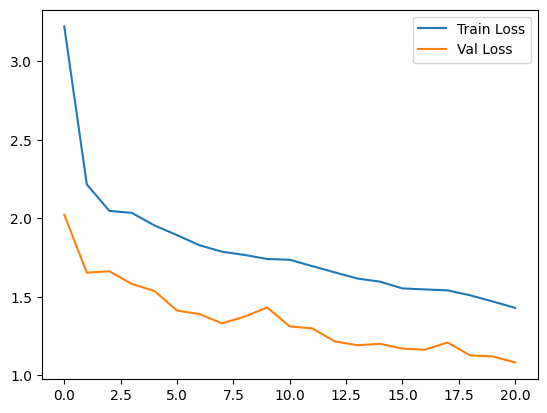

In [37]:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.show()

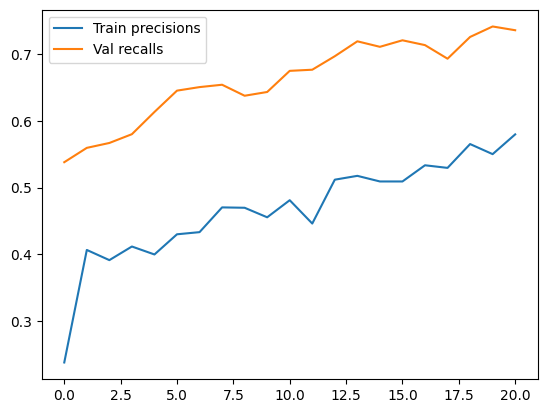

In [38]:
plt.plot(val_precisions, label="Train precisions")
plt.plot(val_recalls, label="Val recalls")
plt.legend()
plt.show()

# Inference пример

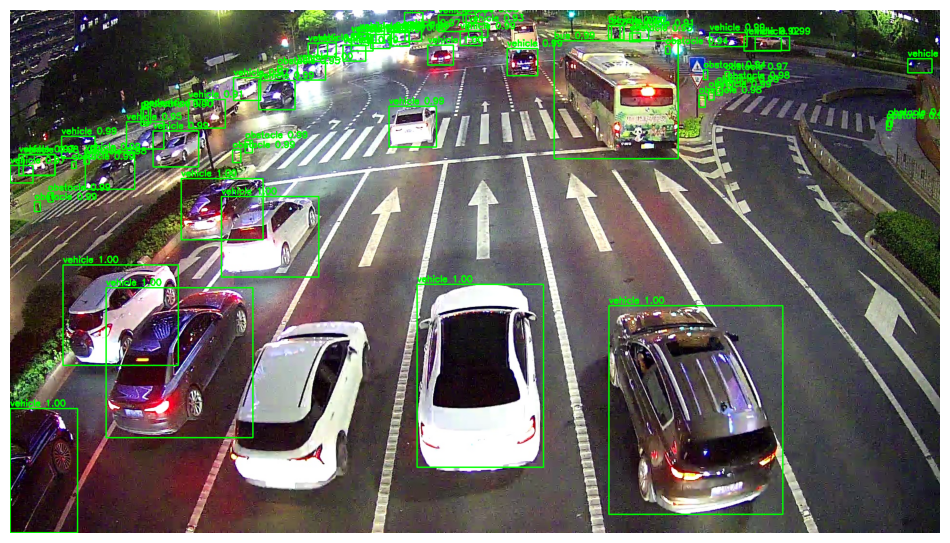

In [39]:
model.eval()
index_picture = 270

sample = val_dataset[index_picture]
pixel_values = sample["pixel_values"].unsqueeze(0).to(device)

with torch.no_grad():
    outputs = model(pixel_values=pixel_values)

# load raw image
image = np.array(cv2.imread(
    "/kaggle/input/intersection-flow-5k/Intersection-Flow-5K/images/val/" + val_dataset.image_files[index_picture]
))
orig_h, orig_w = image.shape[:2]

# DETR postprocess
target_sizes = torch.tensor([[orig_h, orig_w]])
results = image_processor.post_process_object_detection(
    outputs, target_sizes=target_sizes, threshold=0.9
)[0]

# predicted
boxes = results["boxes"].cpu().numpy()
labels = results["labels"].cpu().numpy()
scores = results["scores"].cpu().numpy()

id2label = {v: k for k, v in class2id.items()}

img_vis = image.copy()

# draw predicted boxes (green)
for box, cls, score in zip(boxes, labels, scores):
    x1, y1, x2, y2 = box.astype(int)
    cv2.rectangle(img_vis, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(
        img_vis,
        f"{id2label[cls]} {score:.2f}",
        (x1, y1 - 5),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.6,
        (0, 255, 0),
        2
    )


# plot
plt.figure(figsize=(12, 12))
plt.imshow(cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


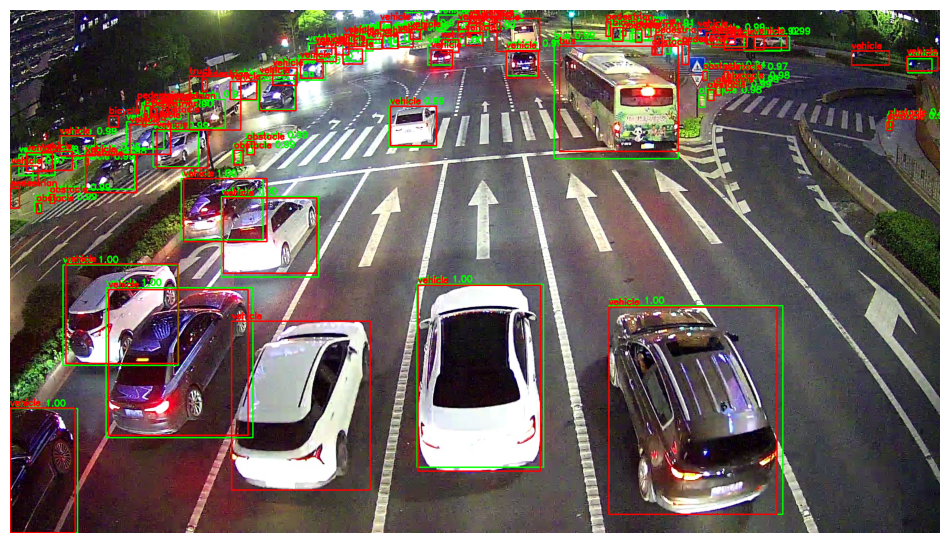

In [40]:
# ==========================
# add ground truth (RED)
# ==========================

# gt boxes come from original annotation
gt_boxes_xywh = sample['labels']['boxes']  # tensor [N, 4] in xywh
gt_labels = sample['labels']['class_labels']

# check if tensor needs to be scaled
# if boxes are normalized – multiply by size
if gt_boxes_xywh.max() <= 1.0:
    gt_boxes_xywh = gt_boxes_xywh.clone()
    gt_boxes_xywh[:, 0] *= orig_w  # cx
    gt_boxes_xywh[:, 1] *= orig_h  # cy
    gt_boxes_xywh[:, 2] *= orig_w  # w
    gt_boxes_xywh[:, 3] *= orig_h  # h

# convert xywh → xyxy
gt_boxes = []
for (cx, cy, w, h) in gt_boxes_xywh:
    x1 = cx - w/2
    y1 = cy - h/2
    x2 = cx + w/2
    y2 = cy + h/2
    gt_boxes.append([int(x1), int(y1), int(x2), int(y2)])

# draw gt boxes (red)
for box, cls in zip(gt_boxes, gt_labels):
    x1, y1, x2, y2 = box
    cv2.rectangle(img_vis, (x1, y1), (x2, y2), (0, 0, 255), 2)
    cv2.putText(
        img_vis,
        id2label[int(cls)],
        (x1, y1 - 5),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.6,
        (0, 0, 255),
        2
    )
# plot
plt.figure(figsize=(12, 12))
plt.imshow(cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [41]:
#sample['labels']

In [42]:
model.eval()

all_prec, all_rec = [], []

with torch.no_grad():
    for batch in tqdm(test_loader):
        pixel_values = batch["pixel_values"].to(device)
        labels_batch = batch["labels"]  # истинная разметка

        # инференс модели
        outputs = model(pixel_values=pixel_values)

        # размеры оригинальных изображений
        sizes = []
        for t in labels_batch:
            h, w = t["orig_size"].tolist()
            sizes.append((h, w))

        # постпроцесс
        results_batch = image_processor.post_process_object_detection(
            outputs, target_sizes=sizes, threshold=0.5
        )

        # вычисление метрик по батчу
        for res, target in zip(results_batch, labels_batch):
            
            pred_boxes = res["boxes"].cpu().numpy()      # xyxy пиксели
            pred_labels = res["labels"].cpu().numpy()
        
            orig_h, orig_w = target["orig_size"].tolist()
        
            gt = target["boxes"].cpu().numpy()           # xywh нормализованный
        
            gt_xyxy = np.zeros_like(gt)
            gt_xyxy[:, 0] = (gt[:, 0] - gt[:, 2] / 2) * orig_w
            gt_xyxy[:, 1] = (gt[:, 1] - gt[:, 3] / 2) * orig_h
            gt_xyxy[:, 2] = (gt[:, 0] + gt[:, 2] / 2) * orig_w
            gt_xyxy[:, 3] = (gt[:, 1] + gt[:, 3] / 2) * orig_h
        
            gt_labels = target["class_labels"].cpu().numpy()
        
            prec, rec = compute_simple_map(
                pred_boxes,
                pred_labels,
                gt_xyxy,
                gt_labels,
                iou_threshold=0.5
            )
        
            all_prec.append(prec)
            all_rec.append(rec)

# итоговые
mean_prec = np.mean(all_prec)
mean_rec = np.mean(all_rec)

print(f"Precision: {mean_prec:.4f}  Recall: {mean_rec:.4f}")


100%|██████████| 91/91 [00:51<00:00,  1.78it/s]

Precision: 0.5833  Recall: 0.7302


# Map@0.9

In [ ]:
model.eval()

all_prec, all_rec = [], []

with torch.no_grad():
    for batch in tqdm(test_loader):
        pixel_values = batch["pixel_values"].to(device)
        labels_batch = batch["labels"]  # истинная разметка

        # инференс модели
        outputs = model(pixel_values=pixel_values)

        # размеры оригинальных изображений
        sizes = []
        for t in labels_batch:
            h, w = t["orig_size"].tolist()
            sizes.append((h, w))

        # постпроцесс
        results_batch = image_processor.post_process_object_detection(
            outputs, target_sizes=sizes, threshold=0.5
        )

        # вычисление метрик по батчу
        for res, target in zip(results_batch, labels_batch):
            
            pred_boxes = res["boxes"].cpu().numpy()      # xyxy пиксели
            pred_labels = res["labels"].cpu().numpy()
        
            orig_h, orig_w = target["orig_size"].tolist()
        
            gt = target["boxes"].cpu().numpy()           # xywh нормализованный
        
            gt_xyxy = np.zeros_like(gt)
            gt_xyxy[:, 0] = (gt[:, 0] - gt[:, 2] / 2) * orig_w
            gt_xyxy[:, 1] = (gt[:, 1] - gt[:, 3] / 2) * orig_h
            gt_xyxy[:, 2] = (gt[:, 0] + gt[:, 2] / 2) * orig_w
            gt_xyxy[:, 3] = (gt[:, 1] + gt[:, 3] / 2) * orig_h
        
            gt_labels = target["class_labels"].cpu().numpy()
        
            prec, rec = compute_simple_map(
                pred_boxes,
                pred_labels,
                gt_xyxy,
                gt_labels,
                iou_threshold=0.9
            )
        
            all_prec.append(prec)
            all_rec.append(rec)

# итоговые
mean_prec = np.mean(all_prec)
mean_rec = np.mean(all_rec)

print(f"Precision: {mean_prec:.4f}  Recall: {mean_rec:.4f}")


 44%|████▍     | 40/91 [00:27<00:34,  1.49it/s]

In [ ]:
model.save_pretrained(f"/kaggle/working/detr-best-test-epoch{epoch+1}")
image_processor.save_pretrained(f"/kaggle/working/detr-best-test-epoch{epoch+1}")